In [1]:
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
import ardent
# from scipy.ndimage import zoom
import time
import os
import pandas as pd

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
# from proglearn.sims import generate_gaussian_parity

import pandas as pd
import SimpleITK as sitk
# from skimage.transform import rotate

In [2]:
context = sns.plotting_context(context="talk", font_scale=1)
sns.set_context(context)

In [3]:
from sklearn.datasets import make_blobs


def _generate_2d_rotation(theta=0):
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    return R


def generate_gaussian_parity(
    n_samples,
    centers=None,
    class_label=None,
    cluster_std=0.25,
    angle_params=None,
    random_state=None,
):

    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])

    if class_label == None:
        class_label = [0, 1, 1, 0]

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X, y = make_blobs(
        n_samples=samples_per_blob,
        n_features=2,
        centers=centers,
        cluster_std=cluster_std,
    )

    for blob in range(blob_num):
        y[np.where(y == blob)] = class_label[blob]

    if angle_params != None:
        R = _generate_2d_rotation(angle_params)
        X = X @ R

    return X, y

In [4]:
def init_forest(max_depth):
    # np.random.seed(1)
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    return progressive_learner, uf

In [5]:
def grid_to_pred(task_pos_reshaped, test_task, xx, yy):
    pred = np.empty((len(test_task), ))

    for i in range(len(test_task)):
        x_ind = np.where(test_task[i,0] <= xx[0,:])[0][0]
        y_ind = np.where(test_task[i,1] <= yy[:,0])[0][0]
        pred[i] = task_pos_reshaped[y_ind, x_ind]

    pred = pred.reshape((-1,1))
    pred = np.hstack((pred, 1-pred))
    pred = np.argmax(pred, axis=1)
    
    return pred

In [6]:
def to_grid(test_task1, test_task2):
    h = 0.01
    x_min1, x_max1 = test_task1[:,0].min(), test_task1[:,0].max()
    y_min1, y_max1 = test_task1[:,1].min(), test_task1[:,1].max()
    x_min2, x_max2 = test_task2[:,0].min(), test_task2[:,0].max()
    y_min2, y_max2 = test_task2[:,1].min(), test_task2[:,1].max()

    x_min = min(x_min1, x_min2) - 0.1
    x_max = max(x_max1, x_max2) + 0.1
    y_min = min(y_min1, y_min2) - 0.1
    y_max = max(y_max1, y_max2) + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    new_test_task = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, new_test_task

In [45]:
n_task1=100; n_task2=100; max_depth=7; affines=None; n_test=1000; task1_angle=0; task2_angle=np.pi/4; n_trees=10

In [46]:
np.random.seed(1)
#source data
X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)
#target data
X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

xx2, yy2, test_task2_grid = to_grid(test_task1, test_task2)
errors = np.zeros(6, dtype=float)

# L2F
np.random.seed(1)
l2f, uf = init_forest(max_depth)
l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
l2f.add_task(X_task2, y_task2, num_transformers=n_trees)

# UF
uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)

In [7]:
def generate_posteriors(X, task_id, forest, transformers):
    vote_per_transformer_id = []
    for transformer_id in transformers:
        vote_per_bag_id = []
        for bag_id in range(
            len(forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id])
        ):
            transformer = forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id][
                bag_id
            ]
            X_transformed = transformer.transform(X)
            voter = forest.task_id_to_decider[task_id].transformer_id_to_voters_[transformer_id][bag_id]
            vote = voter.predict_proba(X_transformed)
            vote_per_bag_id.append(vote)
        vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

    return vote_per_transformer_id

In [8]:
def lddmm_reg(in_task_pos_reshaped, cross_task_pos_reshaped, affines, n_ite, calibrate):
    print("start running lddmm")
    transform = ardent.Transform()
    reference = in_task_pos_reshaped
    moving = cross_task_pos_reshaped
    # n_ite = 50
    try:
        transform.register(target=moving, template=reference, num_iterations=n_ite, initial_affine=affines, calibrate=calibrate)
    except RuntimeError:
        try:
            transform.register(target=moving, template=reference, affine_stepsize=0.2, num_iterations=n_ite, initial_affine=affines)
        except RuntimeError:
            try:
                transform.register(target=moving, template=reference, affine_stepsize=0.1, num_iterations=n_ite, initial_affine=affines)
            except:
                return None, None, None
        except:
            return None, None, None
    except:
        return None, None, None

    deformed_moving = transform.transform_image(
        subject=moving,
        output_shape=moving.shape,
        deform_to='template')

    deformed_reference = transform.transform_image(
        subject=reference,
        output_shape=reference.shape,
        deform_to='target'
    )
    print("finish running lddmm")
    return deformed_moving, deformed_reference, transform

In [49]:
np.random.seed(1)

l2f_task1 = generate_posteriors(test_task2_grid, 0, l2f, [0,1])
l2f_task2 = generate_posteriors(test_task2_grid, 1, l2f, [0,1])

task1pred1_reshaped = l2f_task1[0][:,0].reshape(xx2.shape)
task1pred2_reshaped = l2f_task1[1][:,0].reshape(xx2.shape)
task2pred1_reshaped = l2f_task2[0][:,0].reshape(xx2.shape)
task2pred2_reshaped = l2f_task2[1][:,0].reshape(xx2.shape)

In [60]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(task1pred1_reshaped))
elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(task2pred2_reshaped))
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
elastixImageFilter.Execute()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7fa0395cc960> >

In [85]:
init_a = np.array([[1.416, -0.079,0],[-0.002,1.269,0],[-2.448,-1.040,1]])
init_a.T

array([[ 1.416e+00, -2.000e-03, -2.448e+00],
       [-7.900e-02,  1.269e+00, -1.040e+00],
       [ 0.000e+00,  0.000e+00,  1.000e+00]])

In [56]:
np.random.seed(1)
task2pred2_deformed, task1pred1_deformed, model1 = lddmm_reg(task2pred2_reshaped, task1pred1_reshaped, None, 50, False)

start running lddmm
finish running lddmm


In [84]:
model1.affine

array([[ 0.8228377 , -0.56827645,  6.15804883],
       [ 0.56827645,  0.8228377 ,  2.43993268],
       [ 0.        ,  0.        ,  1.        ]])

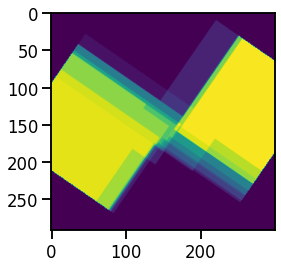

In [38]:
plt.imshow(task2pred2_deformed)

In [57]:
vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)
errors[1] = 1 - np.mean(grid_to_pred(vote1, test_task1, xx2, yy2) == test_label_task1)  # l2f task1 error

vote2 = np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)
errors[3] = 1 - np.mean(grid_to_pred(vote2, test_task2, xx2, yy2) == test_label_task2)  # l2f task2 error

vote3 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)
errors[4] = 1 - np.mean(grid_to_pred(vote3, test_task1, xx2, yy2) == test_label_task1)  # l2f o lddmm task1 error
vote4 = np.mean([task2pred2_reshaped, task2pred2_deformed], axis=0)
errors[5] = 1 - np.mean(grid_to_pred(vote4, test_task2, xx2, yy2) == test_label_task2)  # l2f o lddmm task2 error

In [58]:
errors

array([0.045, 0.061, 0.   , 0.072, 0.058, 0.051])

In [9]:
def run_elastix(task1pred1_reshaped, task2pred2_reshaped):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(task1pred1_reshaped))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(task2pred2_reshaped))
    ParamMap = sitk.GetDefaultParameterMap('affine')
    ParamMap['AutomaticTransformInitialization'] = ['true']
    ParamMap['AutomaticTransformInitializationMethod'] = ['GeometricalCenter']
    ParamMap['Metric'] = ['AdvancedMeanSquares']
    # ParamMap['MaximumNumberOfIterations'] = ['512']
    # ParamMap['UseDirectionCosines'] = ['true']
    # ParamMap['NumberOfResolutions'] = ['2']
    # ParamMap['NumberOfSpatialSamples'] = ['3000']
    # ParamMap['UseAdaptiveStepSizes'] = ['true']

    # elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
    # elastixImageFilter.AddParameter( "Metric", "CorrespondingPointsEuclideanDistanceMetric")
    # Set the parameter map:
    elastixImageFilter.SetParameterMap(ParamMap)

    # Register the 3D images:
    elastixImageFilter.Execute()

    # Get the registered image:
    RegIm = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    params = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
    
    return RegIm, params

In [10]:
def params_to_mat(params):
    init_affines = np.eye(3)
    init_affines[0,:2] = [float(params[0]), float(params[2])]
    init_affines[1,:2] = [float(params[1]), float(params[3])]
    init_affines[2,:2] = [float(params[4]), float(params[5])]
    return init_affines.T

In [26]:
def exp(n_task1, n_task2, max_depth, n_test=1000, task1_angle=0, task2_angle=np.pi/4, n_trees=10):
    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    
    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

    xx2, yy2, test_task2_grid = to_grid(test_task1, test_task2)
    errors = np.zeros(7, dtype=float)
    
    l2f, uf = init_forest(max_depth)
    l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
    l2f.add_task(X_task2, y_task2, num_transformers=n_trees)

    l2f_task1 = generate_posteriors(test_task2_grid, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(test_task2_grid, 1, l2f, [0,1])

    task1pred1_reshaped = l2f_task1[0][:,0].reshape(xx2.shape)
    task1pred2_reshaped = l2f_task1[1][:,0].reshape(xx2.shape)
    task2pred1_reshaped = l2f_task2[0][:,0].reshape(xx2.shape)
    task2pred2_reshaped = l2f_task2[1][:,0].reshape(xx2.shape)

    vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)
    errors[1] = 1 - np.mean(
        grid_to_pred(vote1, test_task1, xx2, yy2) == test_label_task1
    )  # l2f task1 error

#     vote2 = np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)
#     errors[3] = 1 - np.mean(
#         grid_to_pred(vote2, test_task2, xx2, yy2) == test_label_task2
#     )  # l2f task2 error
    
    # L2F o elastix task1 error
    task1pred1_deformed, params = run_elastix(task1pred1_reshaped, task2pred2_reshaped)
    vote3 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)
    errors[4] = 1 - np.mean(
        grid_to_pred(vote3, test_task1, xx2, yy2) == test_label_task1
    )  
    
#     # l2f o lddmm task1 error
#     _, task1pred1_deformed_lddmm, _ = lddmm_reg(task2pred2_reshaped, task1pred1_reshaped, None, 50, False)    
#     vote4 = np.mean([task1pred1_reshaped, task1pred1_deformed_lddmm], axis=0)
#     errors[5] = 1 - np.mean(
#         grid_to_pred(vote4, test_task1, xx2, yy2) == test_label_task1
#     )  
    
    # l2f o elastix o lddmm  task1 error
    init_affines = params_to_mat(params)
    _, task1pred1_deformed_lddmm_sitk, _ = lddmm_reg(task2pred2_reshaped, task1pred1_reshaped, init_affines, 50, False)    
    vote5 = np.mean([task1pred1_reshaped, task1pred1_deformed_lddmm_sitk], axis=0)
    errors[6] = 1 - np.mean(
        grid_to_pred(vote5, test_task1, xx2, yy2) == test_label_task1
    )  

    # UF
    uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)

    uf_task1 = generate_posteriors(test_task2_grid, 0, uf, [0])
    uf_task2 = generate_posteriors(test_task2_grid, 1, uf, [0])

    task1pred1_reshaped_uf = uf_task1[0][:,0].reshape(xx2.shape)
    task2pred1_reshaped_uf = uf_task2[0][:,0].reshape(xx2.shape)

    errors[0] = 1 - np.mean(
        grid_to_pred(task1pred1_reshaped_uf, test_task1, xx2, yy2) == test_label_task1
    )  # uf task1 error
#     errors[2] = 1 - np.mean(
#         grid_to_pred(task2pred1_reshaped_uf, test_task2, xx2, yy2) == test_label_task2
#     )  # uf task2 error

    return errors

In [50]:
start_time = time.time()
errors = exp(n_task1=100, n_task2=100, max_depth=7, task2_angle=np.pi*(45/180))
print("--- %s seconds ---" % (time.time() - start_time))

start running lddmm
finish running lddmm
start running lddmm
finish running lddmm
--- 50.16991448402405 seconds ---


In [51]:
errors

array([0.061, 0.059, 0.   , 0.   , 0.13 , 0.109, 0.1  ])

In [27]:
# start_time = time.time()
errors1 = Parallel(n_jobs=-1, verbose=1)(
    delayed(exp)(
        100, 100, ceil(log2(100)), task2_angle=np.pi*(45/180)
    ) for _ in range(16)
)
# print("--- %s seconds ---" % (time.time() - start_time))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.5min finished


In [28]:
errors1

[array([0.05 , 0.066, 0.   , 0.   , 0.073, 0.   , 0.057]),
 array([0.058, 0.059, 0.   , 0.   , 0.057, 0.   , 0.057]),
 array([0.062, 0.046, 0.   , 0.   , 0.047, 0.   , 0.047]),
 array([0.148, 0.076, 0.   , 0.   , 0.074, 0.   , 0.068]),
 array([0.062, 0.065, 0.   , 0.   , 0.059, 0.   , 0.058]),
 array([0.049, 0.058, 0.   , 0.   , 0.121, 0.   , 0.084]),
 array([0.061, 0.068, 0.   , 0.   , 0.069, 0.   , 0.102]),
 array([0.072, 0.07 , 0.   , 0.   , 0.078, 0.   , 0.056]),
 array([0.06 , 0.068, 0.   , 0.   , 0.054, 0.   , 0.052]),
 array([0.079, 0.115, 0.   , 0.   , 0.121, 0.   , 0.069]),
 array([0.073, 0.062, 0.   , 0.   , 0.07 , 0.   , 0.057]),
 array([0.058, 0.086, 0.   , 0.   , 0.133, 0.   , 0.089]),
 array([0.051, 0.083, 0.   , 0.   , 0.081, 0.   , 0.073]),
 array([0.048, 0.052, 0.   , 0.   , 0.069, 0.   , 0.062]),
 array([0.059, 0.061, 0.   , 0.   , 0.072, 0.   , 0.084]),
 array([0.053, 0.12 , 0.   , 0.   , 0.081, 0.   , 0.093])]

In [29]:
for i in [1,6]:
    print(np.mean(np.array(errors1)[:,0]) / np.mean(np.array(errors1)[:,i]))

0.9030303030303037
0.9413357400722027


In [24]:
errors1

[array([0.056, 0.065, 0.   , 0.   , 0.1  , 0.066, 0.071]),
 array([0.054, 0.067, 0.   , 0.   , 0.064, 0.061, 0.058]),
 array([0.065, 0.094, 0.   , 0.   , 0.093, 0.066, 0.06 ]),
 array([0.086, 0.074, 0.   , 0.   , 0.066, 0.667, 0.064]),
 array([0.111, 0.105, 0.   , 0.   , 0.105, 0.116, 0.111]),
 array([0.051, 0.079, 0.   , 0.   , 0.074, 0.639, 0.055]),
 array([0.059, 0.044, 0.   , 0.   , 0.067, 0.046, 0.039]),
 array([0.046, 0.049, 0.   , 0.   , 0.054, 0.404, 0.054]),
 array([0.066, 0.069, 0.   , 0.   , 0.073, 0.063, 0.065]),
 array([0.054, 0.083, 0.   , 0.   , 0.08 , 0.35 , 0.062]),
 array([0.058, 0.107, 0.   , 0.   , 0.064, 0.635, 0.064]),
 array([0.053, 0.052, 0.   , 0.   , 0.086, 0.074, 0.05 ]),
 array([0.065, 0.064, 0.   , 0.   , 0.106, 0.079, 0.063]),
 array([0.061, 0.066, 0.   , 0.   , 0.079, 0.645, 0.065]),
 array([0.046, 0.052, 0.   , 0.   , 0.077, 0.068, 0.065]),
 array([0.067, 0.075, 0.   , 0.   , 0.071, 0.068, 0.069])]

In [27]:
for i in [1,4,5,6]:
    print(np.mean(np.array(errors1)[:,0]) / np.mean(np.array(errors1)[:,i]))

0.871615720524018
0.792692613185068
0.24660242154682488
0.9832512315270939


In [98]:
params = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
params

('1.41646', '-0.078515', '-0.00196555', '1.26925', '-2.44777', '-1.04002')

In [64]:
fixed_image = sitk.GetImageFromArray(task1pred1_reshaped)
moving_image = sitk.GetImageFromArray(task2pred2_reshaped)

In [251]:
registration_transform = sitk.CenteredTransformInitializer(fixed_image, 
                          moving_image, 
                          sitk.AffineTransform(2), 
                          sitk.CenteredTransformInitializerFilter.GEOMETRY)
registration_method = sitk.ImageRegistrationMethod()
# registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetInterpolator(sitk.sitkBSpline)
# registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
# registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=10)
# registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
# registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetOptimizerAsGradientDescent(learningRate=0.01, numberOfIterations=1000, convergenceMinimumValue=1e-8, convergenceWindowSize=10)
# registration_method.SetOptimizerScalesFromPhysicalShift() 
registration_method.SetInitialTransform(registration_transform, inPlace=True)
# registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
# registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
# registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration_method.Execute(fixed_image, moving_image)

<SimpleITK.SimpleITK.Transform; proxy of <Swig Object of type 'itk::simple::Transform *' at 0x7f190c1b9e10> >

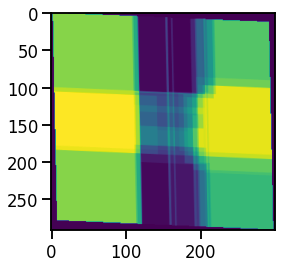

In [252]:
i = sitk.Resample(moving_image, fixed_image, registration_transform)
# i = sitk.GetArrayFromImage(registration_transform.GetResultImage())
plt.imshow(sitk.GetArrayFromImage(i))

In [26]:
print(registration_method.GetMetricValue())
print(registration_method.GetOptimizerStopConditionDescription())

NameError: name 'registration_method' is not defined

In [15]:
plt.imshow(sitk.GetArrayFromImage(elastixImageFilter.GetResultImage()))

NameError: name 'elastixImageFilter' is not defined

In [163]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(src))
elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(dst1))
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
elastixImageFilter.Execute()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7fa03b0ddab0> >

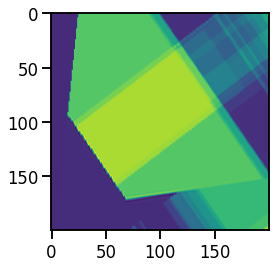

In [164]:
plt.imshow(sitk.GetArrayFromImage(elastixImageFilter.GetResultImage()))

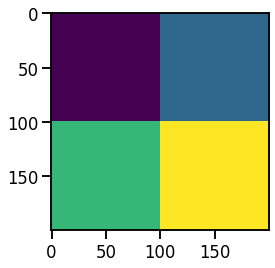

In [120]:
aux = np.ones((100, 100), dtype=int)
src = np.vstack([np.c_[aux, 2*aux], np.c_[3*aux, 4*aux]])
plt.imshow(src)

In [122]:
#pairs and mapping the source matrix to the new indices might be written as follows:

def linear_transformation(src, a):
    M, N = src.shape
    points = np.mgrid[0:N, 0:M].reshape((2, M*N))
    new_points = np.linalg.inv(a).dot(points).round().astype(int)
    x, y = new_points.reshape((2, M, N), order='F')
    indices = x + N*y
    return np.take(src, indices, mode='wrap')

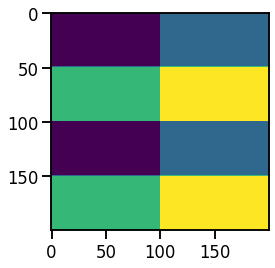

In [160]:
# alpha = np.pi/4
# a = np.array([[np.cos(alpha), -np.sin(alpha)],
#               [np.sin(alpha), np.cos(alpha)]])
a = np.array([[1, 0],
              [0, .5]])
dst = linear_transformation(src, a)
plt.imshow(dst)
plt.show()

In [161]:
dst1 = linear_transformation(task1pred1_deformed, a)

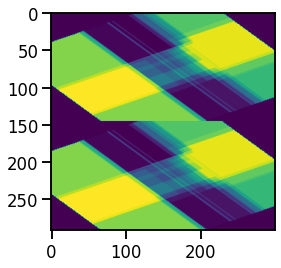

In [162]:
plt.imshow(dst1)

In [146]:
i = np.zeros((100, 2))
j = np.zeros((100, 2))
i[:,0] = np.random.rand(1,100) * 100
j[:,1] = i[:,0]

In [157]:
src.shape

(200, 200)

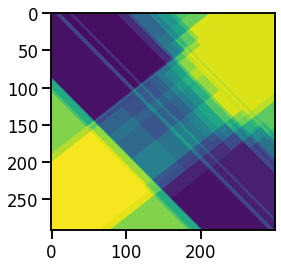

In [43]:
plt.imshow(RegIm)

In [42]:
params = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
params

('0.423837', '-0.419285', '0.421789', '0.538922', '6.91163', '-1.52043')

In [67]:
params_to_mat(params)

array([[ 0.423837,  0.421789,  6.91163 ],
       [-0.419285,  0.538922, -1.52043 ],
       [ 0.      ,  0.      ,  1.      ]])

In [64]:
deformed1, deformed2, model = lddmm_reg(task2pred2_reshaped, task1pred1_reshaped, params_to_mat(params), 50, False)

start running lddmm
finish running lddmm


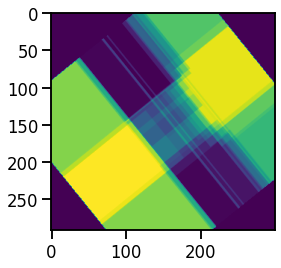

In [65]:
plt.imshow(deformed2)

In [16]:
elastixImageFilter.PrintParameterMap()

<SimpleITK.SimpleITK.ElastixImageFilter; proxy of <Swig Object of type 'itk::simple::ElastixImageFilter::Self *' at 0x7fbd03156de0> >

In [222]:
ParamMap.keys()

['AutomaticParameterEstimation',
 'AutomaticScalesEstimation',
 'AutomaticTransformInitialization',
 'CheckNumberOfSamples',
 'DefaultPixelValue',
 'FinalBSplineInterpolationOrder',
 'FixedImagePyramid',
 'ImageSampler',
 'Interpolator',
 'MaximumNumberOfIterations',
 'MaximumNumberOfSamplingAttempts',
 'Metric',
 'MovingImagePyramid',
 'NewSamplesEveryIteration',
 'NumberOfResolutions',
 'NumberOfSamplesForExactGradient',
 'NumberOfSpatialSamples',
 'Optimizer',
 'Registration',
 'ResampleInterpolator',
 'Resampler',
 'ResultImageFormat',
 'Transform',
 'WriteIterationInfo',
 'WriteResultImage']

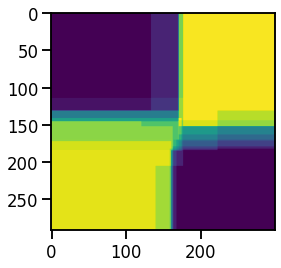

In [19]:
plt.imshow(task1pred1_reshaped)

In [162]:
with open('data.pickle', 'rb') as f:
     data = pickle.load(f)

In [163]:
with open('tmp_data_all.pickle', 'rb') as f:
     tmp_data_all = pickle.load(f)

In [164]:
(X_train, y_train) = data[0]
(X_test, y_test) = data[1]
data_x = np.concatenate([X_train, X_test])
# data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

In [165]:
def cross_val_data(data_x, data_y, total_cls=10):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]


    for i in range(total_cls):
        indx = idx[i]#np.roll(idx[i],(cv-1)*100)
        random.shuffle(indx)

        if i==0:
            train_x1 = x[indx[0:250],:]
            train_x2 = x[indx[250:500],:]
            train_y1 = y[indx[0:250]]
            train_y2 = y[indx[250:500]]

            test_x = x[indx[500:600],:]
            test_y = y[indx[500:600]]
        else:
            train_x1 = np.concatenate((train_x1, x[indx[0:250],:]), axis=0)
            train_x2 = np.concatenate((train_x2, x[indx[250:500],:]), axis=0)
            train_y1 = np.concatenate((train_y1, y[indx[0:250]]), axis=0)
            train_y2 = np.concatenate((train_y2, y[indx[250:500]]), axis=0)

            test_x = np.concatenate((test_x, x[indx[500:600],:]), axis=0)
            test_y = np.concatenate((test_y, y[indx[500:600]]), axis=0)


    return train_x1, train_y1, train_x2, train_y2, test_x, test_y

In [166]:
train_x1, train_y1, train_x2, train_y2, test_x, test_y = cross_val_data(data_x, data_y, total_cls=10)

In [167]:
angle = 30
tmp_data = tmp_data_all[angle]
i = 0
target_image = tmp_data[i][:,:,1]
reference_image = train_x2[i][:,:,1]

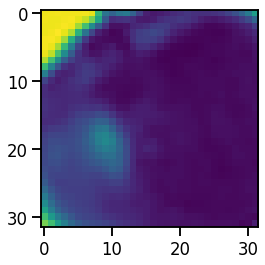

In [168]:
plt.imshow(target_image)

In [21]:
reference_image.shape

(32, 32)

In [193]:
i =8
template = train_x2[i]
target = rotate(template, 30)[:,:,0]
template = template[:,:,0]

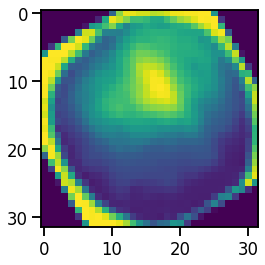

In [194]:
plt.imshow(target)

In [89]:
moving = sitk.GetImageFromArray(task2pred2_reshaped)
fixed = sitk.GetImageFromArray(task1pred2_reshaped)

In [27]:
moving = sitk.Cast(sitk.GetImageFromArray(target_image[:,:,1],isVector=True), sitk.sitkVectorFloat32)
fixed = sitk.Cast(sitk.GetImageFromArray(reference_image[:,:,1],isVector=True), sitk.sitkVectorFloat32)

In [87]:
moving.GetSize()

(300, 292)

In [195]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(template))
elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(target))
ParamMap = sitk.GetDefaultParameterMap('affine')
ParamMap['AutomaticTransformInitialization'] = ['true']
ParamMap['AutomaticTransformInitializationMethod'] = ['GeometricalCenter']
ParamMap['MaximumNumberOfIterations'] = ['1000']
ParamMap['UseDirectionCosines'] = ['true']
# ParamMap['NumberOfResolutions'] = ['2']
# ParamMap['NumberOfSpatialSamples'] = ['3000']
ParamMap['UseAdaptiveStepSizes'] = ['true']

# Set the parameter map:
elastixImageFilter.SetParameterMap(ParamMap)

# elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))

# Register the 3D images:
elastixImageFilter.Execute()

# Get the registered image:
RegIm = elastixImageFilter.GetResultImage()

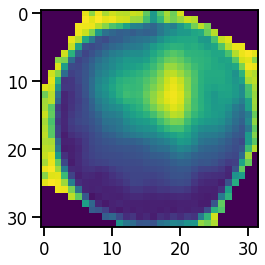

In [196]:
plt.imshow(sitk.GetArrayFromImage(RegIm))

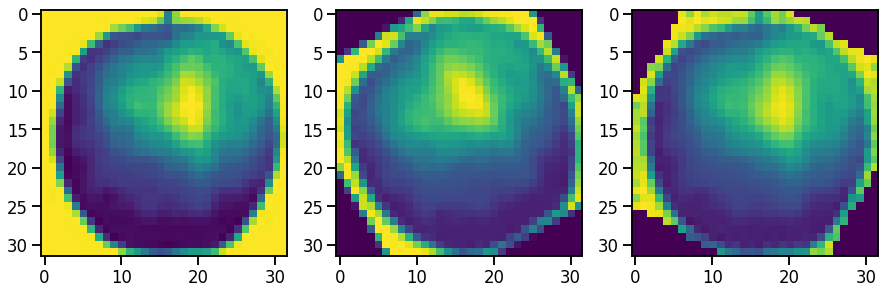

In [197]:
fig,axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(template)
axs[1].imshow(target)
axs[2].imshow(sitk.GetArrayFromImage(RegIm))

In [198]:
print(registration_method.GetMetricValue())

-1.2223414532200563


In [83]:
deformed1, deformed2, model = lddmm_reg(task2pred2_reshaped, task1pred1_reshaped, None, 50, False)

start running lddmm
finish running lddmm


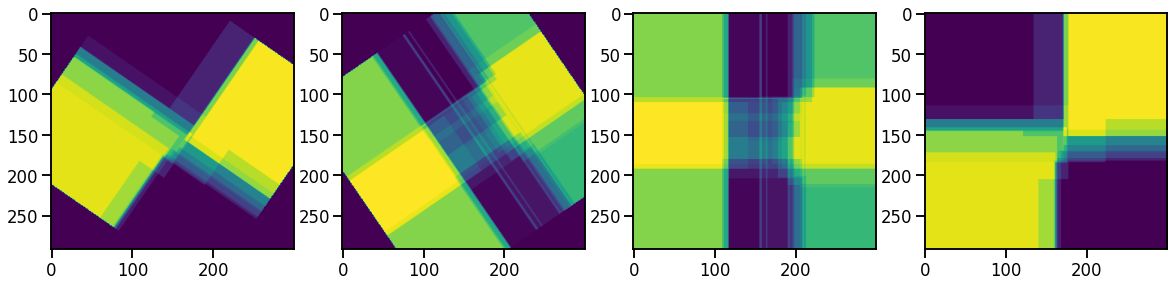

In [85]:
fig,axs = plt.subplots(1,4, figsize=(20,5))
axs[0].imshow(deformed1)
axs[1].imshow(deformed2)
axs[2].imshow(task2pred2_reshaped)
axs[3].imshow(task1pred1_reshaped)

In [ ]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixed)
elastixImageFilter.SetMovingImage(moving)
    
parameterMapVector = sitk.VectorOfParameterMap()
parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
parameterMapVector.append(sitk.GetDefaultParameterMap("bspline"))
elastixImageFilter.SetParameterMap(parameterMapVector)


elastixImageFilter.Execute()
RegIm = elastixImageFilter.GetResultImage()